In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime, timedelta

![routes.png](routes.png)

In [23]:
routes_df = pd.DataFrame({
    "route_code": [
        "2HM2+P8|XJV5+RG",     # Jaya Prakash Narayana Park -> Coles Park, Fraser Town
#        "VJRQ+2M|RMJJ+F4",     # Kudlu Gate Metro Station -> Biocon Campus
#        "WH5F+26|WJ8X+F5W",    # Jaya Prakash Nagar Metro Station -> Hemavathi Park, HSR Layout
#        "XJPW+92|WJP4+FF",     # Swami Vivekananda Road Metro Station -> Christ University, Hosur Main Road
#        "2HVW+G8|XJXR+WG",     # Bethel AG Church, Hebbal -> SMVT Railway Station
#        "WGG8+G5|XH7P+G6",     # The Watering Hole, Rajarajeshwari Nagar -> Sir Puttanna Chetty Town Hall, Bangalore
#        "XPC7+72|XM33+J3",     # The Rameshwaram Cafe @ Brookfield -> Gawky Goose, Wind Tunnel Rd
#        "WHCJ+26|XGCP+FV",     # RV Road Metro Station, Jayanagar 5th Block -> Vijayanagar Metro Station, Chord Road
#        "XMW9+G8|WMJR+V4",     # Benniganahalli Metro Station -> Embassy TechVillage, Devarabisanahalli
#        "XHJ7+MG|WJM6+VC",     # Lulu Mall Bengaluru -> Nexus Mall Koramangala
        "WHR9+R6|XJGF+6J",     # Big Bull Temple, Basavanagudi -> Shri Someshwara Swamy Temple, Halasuru
#        "XJG4+7J|5PX4+HQ",      # MG Road Metro Station -> Kempegowda International Airport, Bengaluru
]})

locations = pd.read_csv("csv-locations_12.9514242_77.6590212.csv").to_dict(orient='list')
locate = lambda plus_code: locations['location'][locations['plus_code'].index(plus_code)]

df = pd.read_csv("csv-bangalore_traffic.csv")
# Keep only those rows of df that correspond to routes in routes_df
df = df[df['route_code'].isin(routes_df['route_code'])]
display(df)

,date,time,route_code,duration,distance
0,2025-09-25,14:25,2HM2+P8|XJV5+RG,32,11.0
11,2025-09-25,14:25,WHR9+R6|XJGF+6J,40,10.7
12,2025-09-25,15:21,2HM2+P8|XJV5+RG,32,10.2
23,2025-09-25,15:21,WHR9+R6|XJGF+6J,40,10.7
24,2025-09-25,16:20,2HM2+P8|XJV5+RG,33,9.9
...,...,...,...,...,...
1933,2025-10-02,14:23,WHR9+R6|XJGF+6J,34,10.1
1935,2025-10-02,15:20,2HM2+P8|XJV5+RG,28,9.9
1945,2025-10-02,15:20,WHR9+R6|XJGF+6J,36,10.7
1947,2025-10-02,16:20,2HM2+P8|XJV5+RG,29,10.2


In [24]:
display(df.describe().round(2))
display(df.describe(exclude='number'))
display(df['route_code'].value_counts())

,duration,distance
count,328.00,328.00
mean,29.13,10.20
std,7.60,0.42
min,17.00,9.30
25%,22.00,9.90
50%,30.00,10.10
75%,34.25,10.70
max,45.00,12.30


,date,time,route_code
count,328,328,328
unique,8,65,2
top,2025-09-26,13:20,2HM2+P8|XJV5+RG
freq,46,14,164


route_code
2HM2+P8|XJV5+RG    164
WHR9+R6|XJGF+6J    164
Name: count, dtype: int64

In [25]:
def transformed_data(df_in):
    df_traffic = df_in.copy()
    df_traffic['year'] = pd.to_datetime(df_traffic['date']).dt.year
    df_traffic['month'] = pd.to_datetime(df_traffic['date']).dt.month
    df_traffic['date'] = pd.to_datetime(df_traffic['date']).dt.day
    df_traffic['hour'] = pd.to_datetime(df_traffic['time'], format='%H:%M', errors='coerce').dt.hour
    df_traffic['day_of_week'] = pd.to_datetime(df_traffic['date']).dt.day_name()
    df_traffic['avg_speed'] = round(df_traffic['distance'] / (df_traffic['duration'] / 60), 2)
    df_traffic['origin'] = df_traffic['route_code'].str.split('|').str[0]
    df_traffic['destination'] = df_traffic['route_code'].str.split('|').str[1]
    df_traffic['origin'] = df_traffic['route_code'].str.split('|').str[0].apply(locate)
    df_traffic['destination'] = df_traffic['route_code'].str.split('|').str[1].apply(locate)
    df_traffic = df_traffic[['year', 'month', 'date', 'hour', 'origin', 'destination', 'duration', 'distance', 'avg_speed']]
    df_traffic = df_traffic.sort_values(['year', 'month', 'date', 'hour', 'avg_speed'],\
                                ascending=[True, True, True, True, True]).reset_index(drop=True)
    return df_traffic

df_traffic = transformed_data(df)
display(df_traffic)

,year,month,date,hour,origin,destination,duration,distance,avg_speed
0,2025,9,25,14,"Big Bull Temple, Basavanagudi","Shri Someshwara Swamy Temple, Halasuru",40,10.7,16.05
1,2025,9,25,14,Jaya Prakash Narayana Park,"Coles Park, Fraser Town",32,11.0,20.62
2,2025,9,25,15,"Big Bull Temple, Basavanagudi","Shri Someshwara Swamy Temple, Halasuru",40,10.7,16.05
3,2025,9,25,15,Jaya Prakash Narayana Park,"Coles Park, Fraser Town",32,10.2,19.12
4,2025,9,25,16,"Big Bull Temple, Basavanagudi","Shri Someshwara Swamy Temple, Halasuru",41,10.7,15.66
...,...,...,...,...,...,...,...,...,...
323,2025,10,2,14,Jaya Prakash Narayana Park,"Coles Park, Fraser Town",30,9.9,19.80
324,2025,10,2,15,"Big Bull Temple, Basavanagudi","Shri Someshwara Swamy Temple, Halasuru",36,10.7,17.83
325,2025,10,2,15,Jaya Prakash Narayana Park,"Coles Park, Fraser Town",28,9.9,21.21
326,2025,10,2,16,"Big Bull Temple, Basavanagudi","Shri Someshwara Swamy Temple, Halasuru",34,10.7,18.88


In [26]:
df_minmax = df_traffic[(df_traffic['hour'] >= 0) & (df_traffic['hour'] <= 23)].copy()

df_minmax['route'] = df_minmax.apply(lambda r: f"{r['origin']} \u2192 {r['destination']}", axis=1)
df_minmax = df_minmax.groupby(['route', 'hour'])['avg_speed'].mean().unstack().reset_index()
df_minmax['variance'] = df_minmax.iloc[:, 1:].apply(lambda row: row.max() - row.min(), axis=1)
df_minmax['max_hour'] = df_minmax.iloc[:, 1:-1].apply(lambda row: row.idxmax(), axis=1)
df_minmax['min_hour'] = df_minmax.iloc[:, 1:-2].apply(lambda row: row.idxmin(), axis=1)

df_minmax[['route', 'max_hour', 'min_hour', 'variance']].\
    sort_values(by='variance', ascending=False).reset_index(drop=True)

hour,route,max_hour,min_hour,variance
0,"Jaya Prakash Narayana Park → Coles Park, Frase...",3,19,18.097143
1,"Big Bull Temple, Basavanagudi → Shri Someshwar...",4,18,15.908571


In [46]:
def plot_traffic_square(df_incoming, height='square'):
    """
    Plot average speed over time for all routes in the raw DataFrame.
    
    Parameters
    ----------
    df_incoming : pd.DataFrame
        Must contain columns: 
        - 'date' (str, YYYY-MM-DD)
        - 'time' (str, HH:MM)
        - 'route' (str, human-readable route name)
        - 'duration' (numeric, minutes)
        - 'distance' (numeric, km)
    height : str, default='square'
        Figure size: 'square' (16, 16), 'wide' (22, 16), or 'extrawide' (28, 16)
        Hour interval: 'square' (1), 'wide' (3), or 'extrawide' (6)
    """
    # 1) Build timestamps and compute average speed
    if df_incoming.empty:
        print("No data available in the dataset.")
        return

    df = df_incoming.copy()
    df['ts'] = pd.to_datetime(df_incoming['date'] + ' ' + df_incoming['time'], errors='coerce')
    df['route'] = df['route_code']
    df = df[['ts', 'route', 'duration', 'distance']]

    # Average speed (km/h) = 60 * distance / duration
    df['avg_speed'] = 60.0 * df['distance'] / df['duration'].replace(0, pd.NA)
        
    # 2) Build a common timeline (all observed timestamps)
    timeline = pd.Index(sorted(df['ts'].unique()))
    
    # 3) Fill missing data and smooth per route
    def fill_and_smooth_route(df):
        """Reindex to timeline, fill missing speeds, and smooth."""
        g = df.set_index('ts').reindex(timeline)
        
        # Fill average speed with neighbor mean
        speeds = pd.to_numeric(g['avg_speed'], errors='coerce')
        prev_vals = speeds.ffill()
        next_vals = speeds.bfill()
        filled = speeds.copy()
        
        mask_missing = speeds.isna()
        mask_both = mask_missing & prev_vals.notna() & next_vals.notna()
        filled.loc[mask_both] = (prev_vals.loc[mask_both] + next_vals.loc[mask_both]) / 2.0
        
        mask_prev_only = mask_missing & prev_vals.notna() & next_vals.isna()
        mask_next_only = mask_missing & next_vals.notna() & prev_vals.isna()
        filled.loc[mask_prev_only] = prev_vals.loc[mask_prev_only]
        filled.loc[mask_next_only] = next_vals.loc[mask_next_only]
        
        g['speed_filled'] = filled
        
        # Smooth the filled speeds (ts is already in the index before reset)
        ts_series = g.index.to_series()
        speed_series = g['speed_filled']
        
        mask_valid = speed_series.notna()
        ts_valid = ts_series[mask_valid]
        speed_valid = speed_series[mask_valid]
        
        if len(speed_valid) < 3:
            g['speed_smooth'] = speed_series
        else:
            try:
                from scipy.interpolate import PchipInterpolator
                x = ts_valid.map(pd.Timestamp.toordinal).to_numpy(dtype=float)
                y = speed_valid.to_numpy(dtype=float)
                x_all = ts_series.map(pd.Timestamp.toordinal).to_numpy(dtype=float)
                interp = PchipInterpolator(x, y)
                g['speed_smooth'] = pd.Series(interp(x_all), index=g.index)
            except Exception:
                # Fallback: centered rolling mean
                win = 3 if len(speed_valid) < 10 else 5
                g['speed_smooth'] = speed_series.rolling(window=win, center=True, min_periods=1).mean()
        
        return g.reset_index(names='ts')

    # Process each route
    frames = []
    for route in sorted(df['route'].unique()):
        route_data = df.loc[df['route'] == route, ['ts', 'route', 'avg_speed']]
        frames.append(fill_and_smooth_route(route_data))
    
    df_filled = pd.concat(frames, ignore_index=True).sort_values(['ts', 'route'])

    # 4) Determine figure size based on height parameter
    figsize = ()
    if height == 'square':
        figsize = (14, 14)
        hour_interval = 1
        legend_fontsize = 12
    elif height == 'wide':
        figsize = (20, 14)
        hour_interval = 3
        legend_fontsize = 14
    elif height == 'extrawide':
        figsize = (26, 14)
        hour_interval = 6
        legend_fontsize = 16
    elif height == 'extrawide2':
        figsize = (30, 12)
        hour_interval = 6
        legend_fontsize = 18
    else:
        raise ValueError(f"height must be 'square', 'wide', or 'extrawide', got: {height}")
    
    # 5) Plot: average speed, legend outside, HH-only x-axis
    hue_order = sorted(df_filled['route'].dropna().unique())
    palette = sns.color_palette("tab20", n_colors=len(hue_order))
    
    plt.figure(figsize=figsize, dpi=300)
    ax = sns.lineplot(
        data=df_filled,
        x='ts', y='speed_smooth',
        hue='route',
        hue_order=hue_order,
        palette=palette,
        linewidth=8, 
        alpha=0.4)
    ax.grid(True, which='both', linestyle='--', linewidth=0.3)
    ax.margins(x=0)
    ax.set_xlim(df_filled['ts'].min(), df_filled['ts'].max())
    ax.tick_params(axis='x', labelsize=legend_fontsize)
    ax.tick_params(axis='y', labelsize=legend_fontsize)
    
    # X-axis as hours only (HH) with dynamic interval
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=hour_interval))
    ax.set_xlabel('Time (Hour)'.upper(), fontsize=legend_fontsize+2)
    ax.set_ylabel('Average Speed (km/h)'.upper(), fontsize=legend_fontsize+2)
    
    # Dynamic title based on time range
    end   = df_filled['ts'].max()
    start = df_filled['ts'].min()
    time_range_hours = (end - start).total_seconds() / 3600
    ax.set_title(f'Average Speeds Over Last {time_range_hours:.0f} Hours', fontsize=legend_fontsize+2)
    
    # Mark midnight with dark vertical lines and add day-of-week labels
    ylim = ax.get_ylim()
    
    # Find all midnight timestamps in the data range
    midnight_times = pd.date_range(
        start=start.normalize() + pd.Timedelta(days=1),
        end=end,
        freq='D')
    
    for midnight in midnight_times:
        # Draw dark vertical line at midnight
        ax.axvline(x=midnight, color='black', linewidth=1, linestyle='-', zorder=1)
        
        # Add day-of-week label at the top, just to the right of the midnight line
        day_name = midnight.strftime('%A')
        ax.text(
            midnight, ylim[1] * 0.98,  # just below top frame
            day_name,
            ha='left',
            va='top',
            fontsize=legend_fontsize,
            fontweight='bold',
            color='black')
    
    # Legend outside on the bottom:
    handles, labels = ax.get_legend_handles_labels()
    leg = ax.legend(
        handles, labels,
        loc='upper center',
        bbox_to_anchor=(0.5, -0.08),
        ncol=2,
        frameon=True,
        borderaxespad=0.0,
        fontsize=legend_fontsize,
        borderpad=1.0,
        labelspacing=0.8
    )
    leg.get_frame().set_linewidth(0.8)
    leg.get_frame().set_edgecolor('#000000')
    plt.subplots_adjust(bottom=0.24)
    plt.tight_layout()
    plt.show()
    
    return df

In [47]:
def plot_route_boxplots(df_incoming, avg_speed=True, duration=True, legend=True):
    """
    Generate boxplots for route metrics.
    
    Parameters
    ----------
    df_incoming : pd.DataFrame
        Must contain columns: ts, route, duration, distance, avg_speed
    plot_type : str, default='both'
        Type of plot to generate:
        - 'speed': Average speed boxplot only
        - 'duration': Duration boxplot only
        - 'both': Both plots side-by-side (default)
    legend : bool, default=True
        If True, show route labels vertically below the x-axis.
        If False, hide x-axis labels.
    """
    df_box = df_incoming.copy()
    df_box['label'] = df_box['route']
    df_box.drop(['route'], axis=1, inplace=True)
    
    # Select metrics based on plot_type
    metrics = {}
    if avg_speed:
        metrics['avg_speed'] = 'Average speed (km/h)'
    if duration:
        metrics['duration'] = 'Duration (minutes)'
    if  metrics == {}:
        raise ValueError("At least one of avg_speed or duration must be True")

    # Sort routes by median avg_speed (descending) - use this order for all plots
    route_order = (
        df_box.groupby('label')['avg_speed']
              .median()
              .sort_values(ascending=False)
              .index.tolist()
    )

    # Create color map
    hue_order = sorted(df_box['label'].unique())
    palette = sns.color_palette("tab20", n_colors=len(hue_order))
    color_map = dict(zip(hue_order, palette))
    
    # Adjust figure size based on number of plots
    figsize = (12, 12) if len(metrics) == 1 else (16, 12)
    if legend:
        figsize = (figsize[0], figsize[1] + 4)
    
    fig, axes = plt.subplots(1, len(metrics), figsize=figsize, sharex=False, dpi=300)
    
    # Ensure axes is always iterable
    if len(metrics) == 1:
        axes = [axes]

    for ax, metric in zip(axes, metrics.keys()):
        sns.boxplot(
            data=df_box,
            x='label',
            y=df_box[metric],
            hue='label',
            order=route_order,
            hue_order=route_order,
            palette=color_map,
            dodge=False, 
            legend=False,
            ax=ax
        )
        
        # Make box faces semi-transparent
        for patch in ax.artists:
            fc = patch.get_facecolor()
            patch.set_facecolor((*fc[:3], 0.4))
        
        for line in ax.lines:
            line.set_alpha(0.4)
        
        ax.set_xlabel('')
        ax.set_ylabel(metrics[metric])
        ax.set_title(f'{metrics[metric]} by Route')
        
        # Control x-axis label visibility based on legend parameter
        if legend:
            ax.tick_params(axis='x', rotation=90, labelbottom=True, bottom=True)
        else:
            ax.tick_params(axis='x', labelbottom=False, bottom=False)
    
    plt.subplots_adjust(bottom=0.35)
    plt.tight_layout()
    plt.show()

In [53]:
# filter_string = "date >= '2025-09-24'"
# df_plot = df.query(filter_string).copy()

NUMBER_OF_DAYS = 1
NUMBER_OF_DAYS = (datetime.now() - timedelta(days=NUMBER_OF_DAYS)).strftime('%Y-%m-%d')
df_plot = df[df['date'] >= NUMBER_OF_DAYS].copy()

df_plot['route_code'] = df_plot['route_code'].\
    apply(lambda r: f"{locate(r.split('|')[0])} \u2192 {locate(r.split('|')[1])}")
df_plot = df_plot[['date', 'time', 'route_code', 'duration', 'distance']].\
    reset_index(drop=True)

display(df_plot.tail(12))

,date,time,route_code,duration,distance
66,2025-10-02,11:20,"Jaya Prakash Narayana Park → Coles Park, Frase...",26,9.9
67,2025-10-02,11:20,"Big Bull Temple, Basavanagudi → Shri Someshwar...",30,10.1
68,2025-10-02,12:22,"Jaya Prakash Narayana Park → Coles Park, Frase...",27,9.9
69,2025-10-02,12:22,"Big Bull Temple, Basavanagudi → Shri Someshwar...",32,10.1
70,2025-10-02,13:20,"Jaya Prakash Narayana Park → Coles Park, Frase...",28,9.9
71,2025-10-02,13:20,"Big Bull Temple, Basavanagudi → Shri Someshwar...",33,10.1
72,2025-10-02,14:23,"Jaya Prakash Narayana Park → Coles Park, Frase...",30,9.9
73,2025-10-02,14:23,"Big Bull Temple, Basavanagudi → Shri Someshwar...",34,10.1
74,2025-10-02,15:20,"Jaya Prakash Narayana Park → Coles Park, Frase...",28,9.9
75,2025-10-02,15:20,"Big Bull Temple, Basavanagudi → Shri Someshwar...",36,10.7


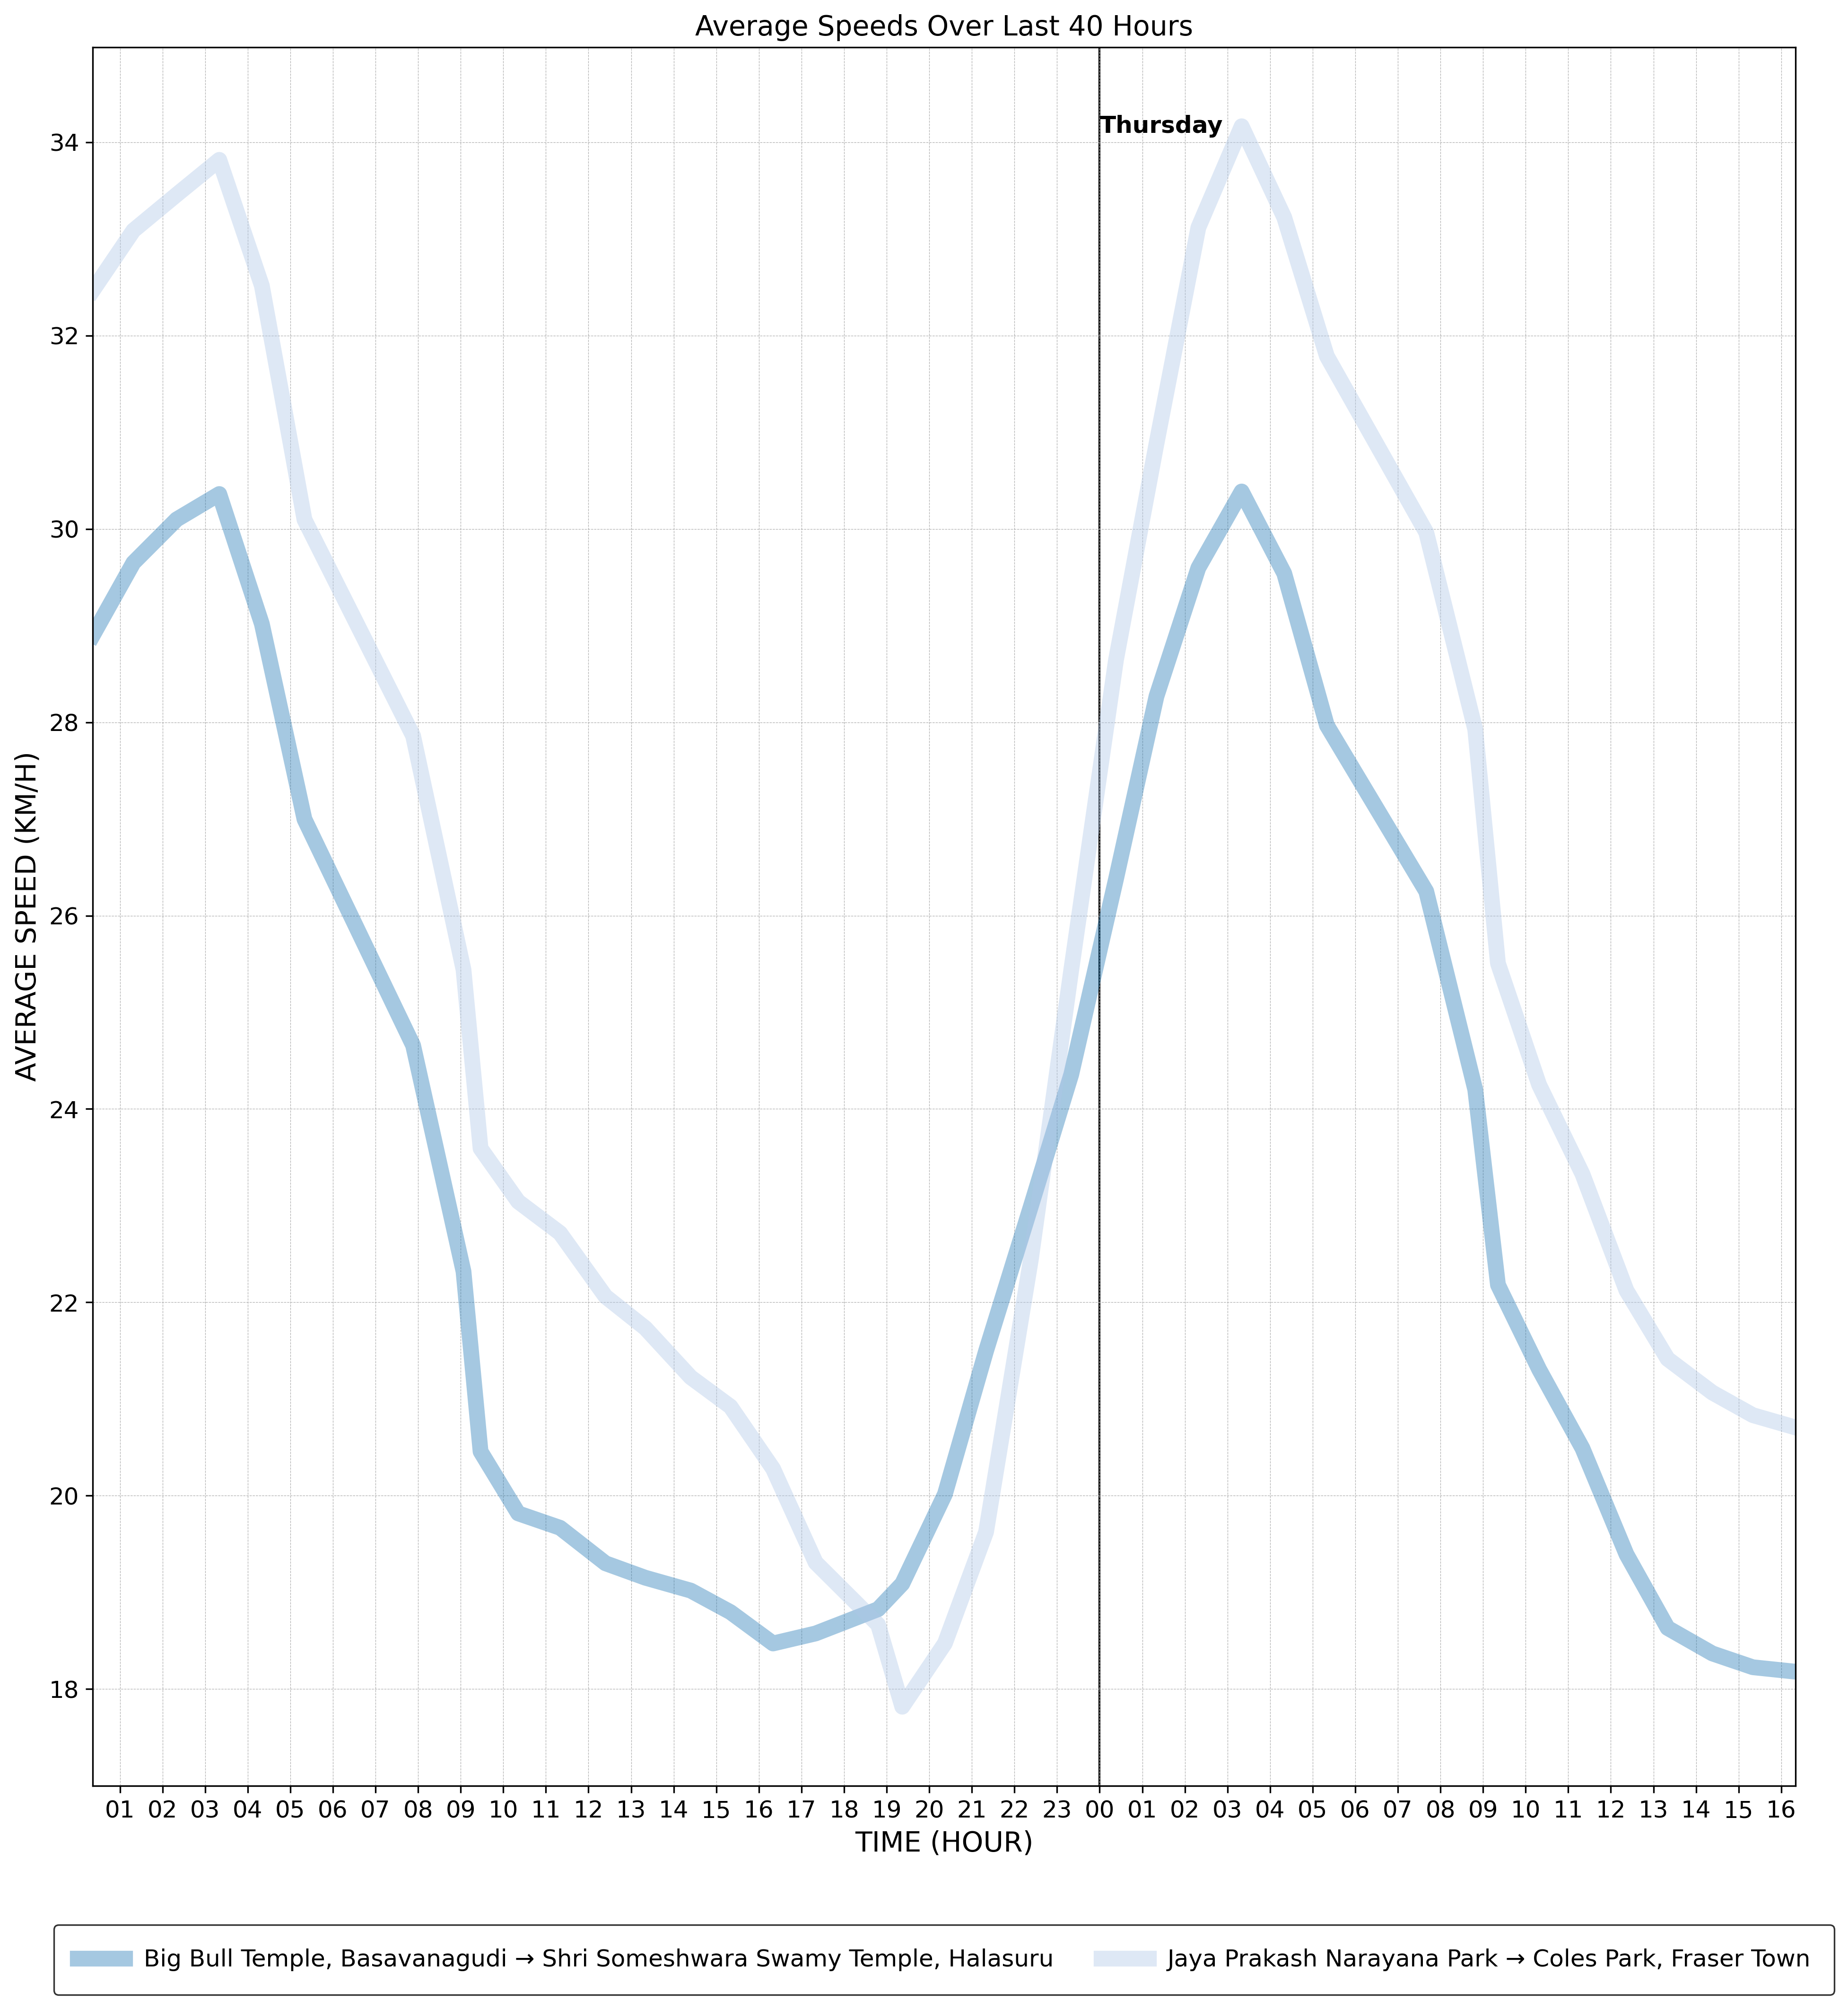

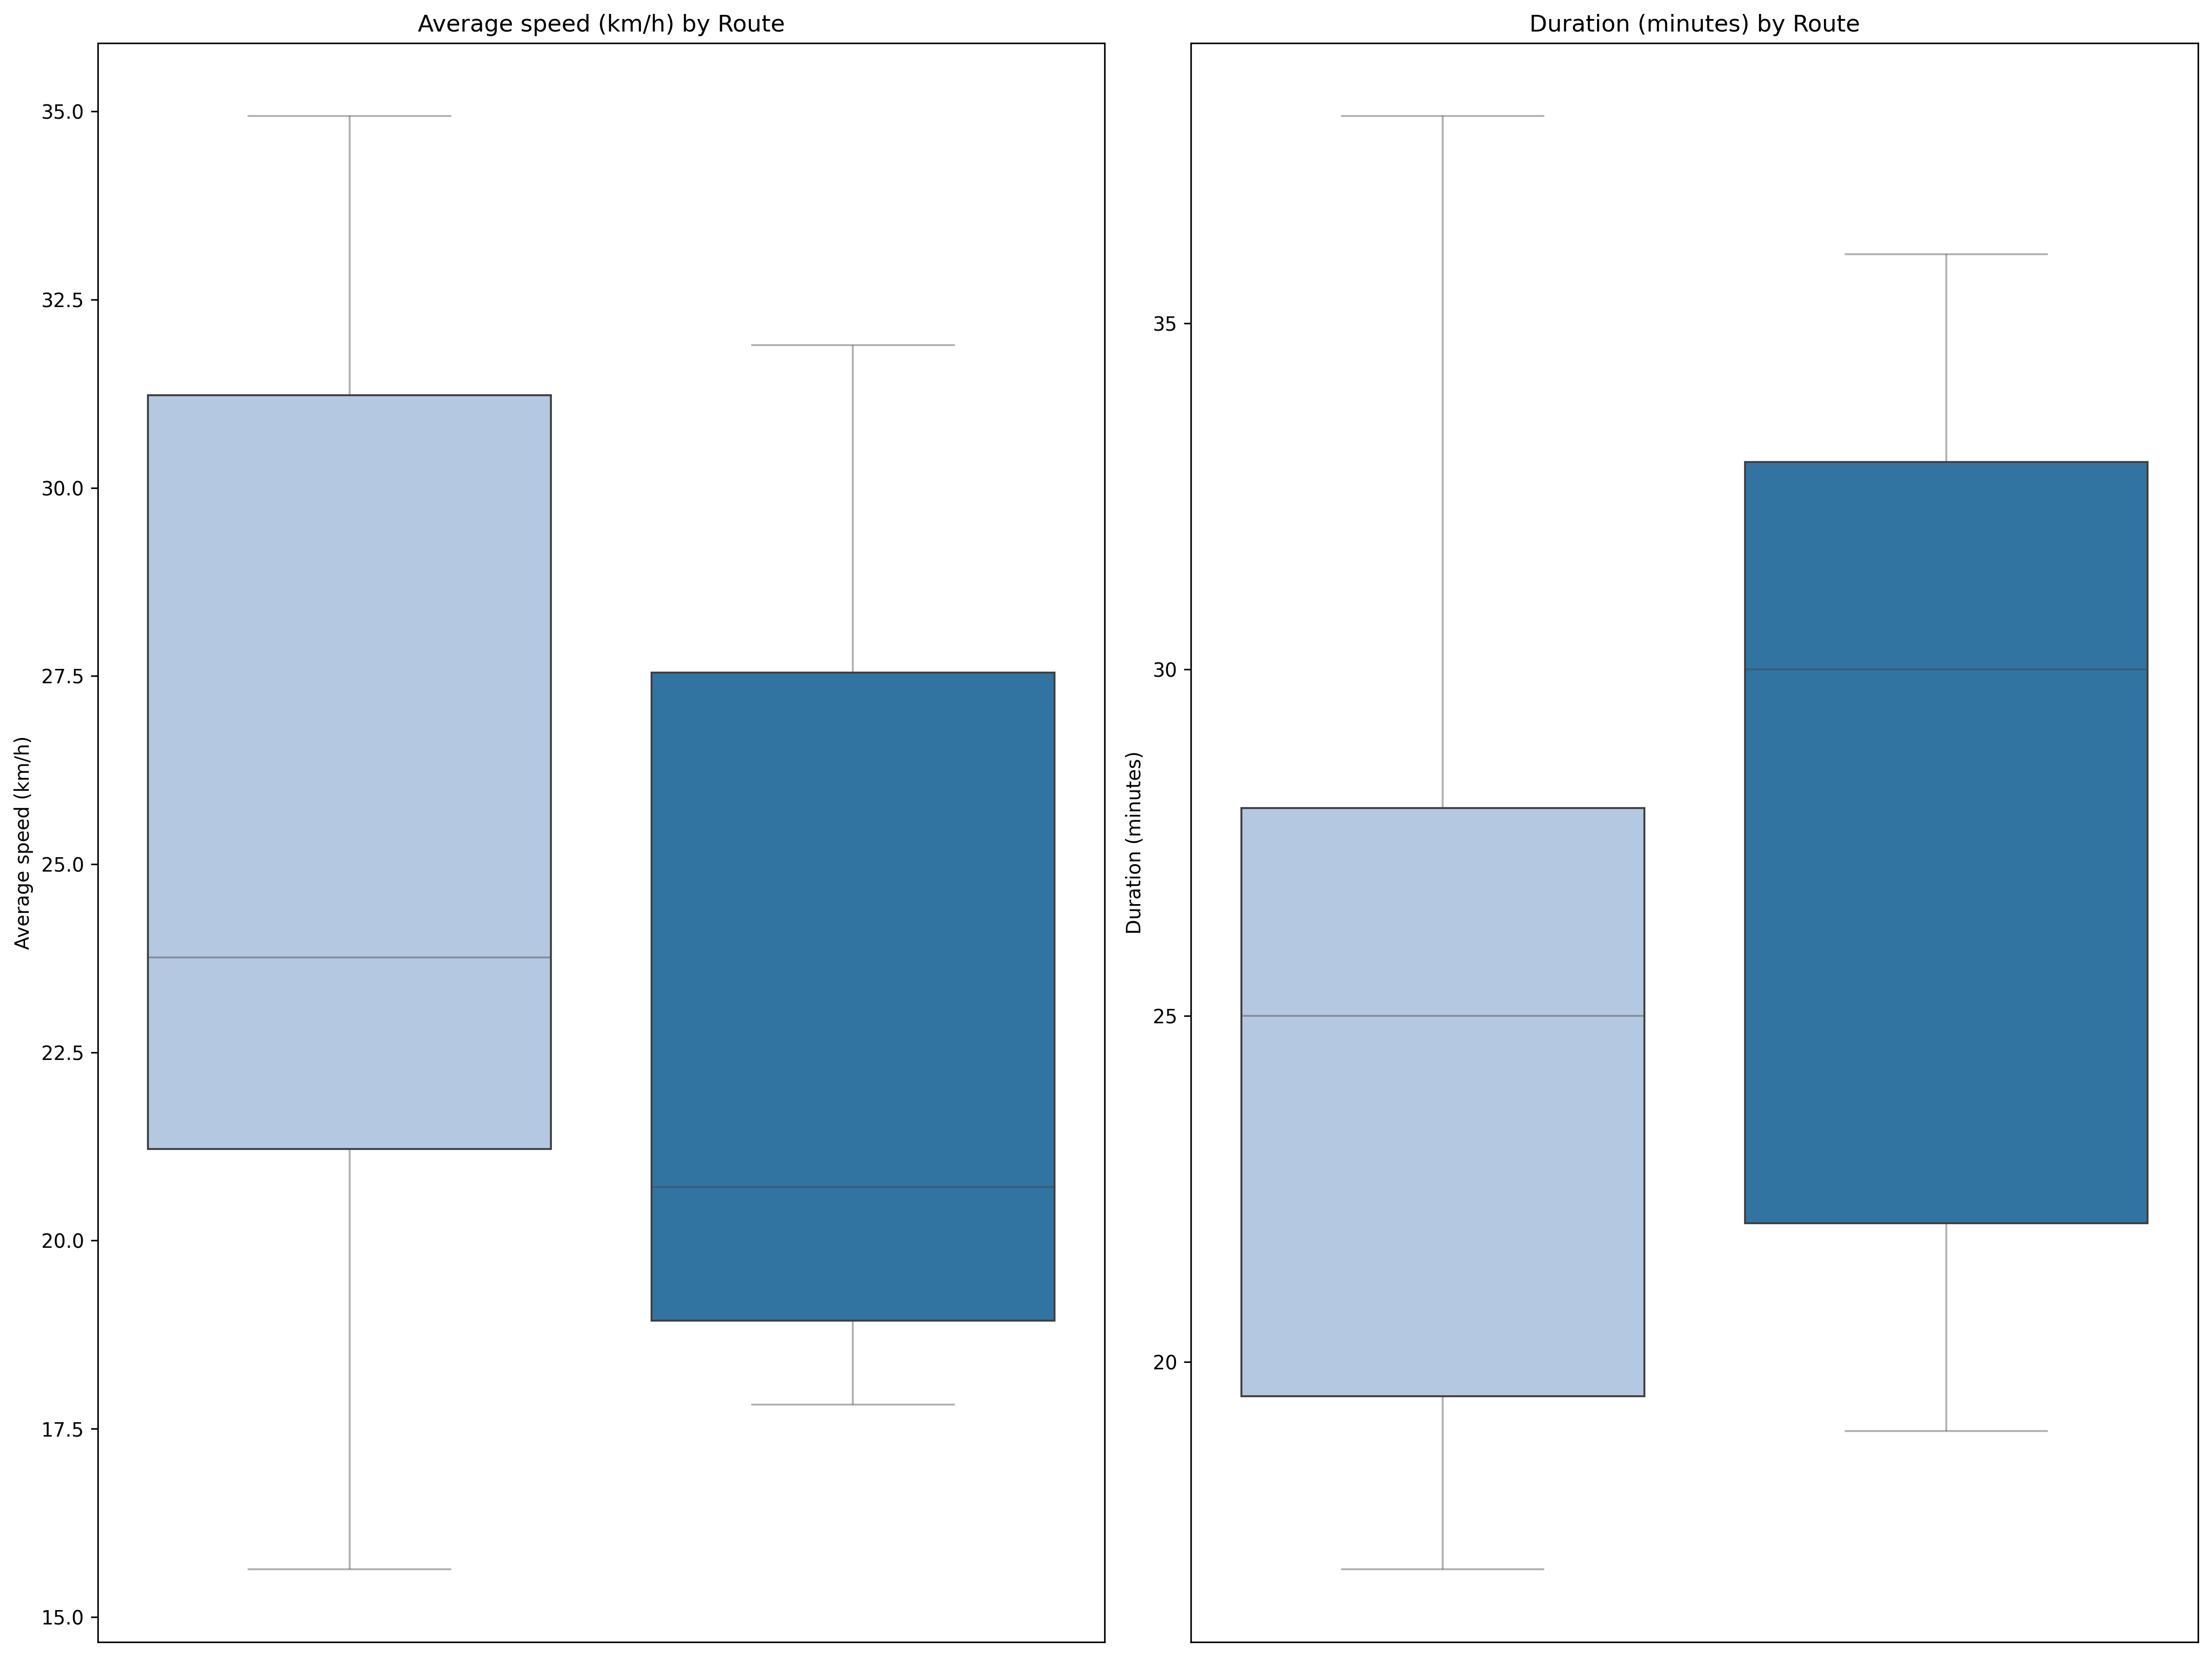

In [54]:
plot_route_boxplots(
    plot_traffic_square(df_plot, height='square'), 
            avg_speed=True, duration=True, legend=False)